<a href="https://colab.research.google.com/github/IImbryk/NMA_MindBigData/blob/work/mnist_for_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Work plan:\
Step 1. Our task. Data description \
Step 2. Load datasets\
Step 3. \


# 1. Our task. Data description

*Predicting the number that a person sees according to EEG data* \
[dataset](http://www.mindbigdata.com/opendb/)

* [id]: a numeric, only for reference purposes.

* [event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

* [device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave, "EP" for Emotive Epoc, "MU" for Interaxon Muse & "IN" for Emotiv Insight.

* [channel]: a string, to indentify the 10/20 brain location of the signal, with possible values:
 
MindWave	"FP1"
EPOC	"AF3, "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"
Muse	"TP9,"FP1","FP2", "TP10"
Insight	"AF3,"AF4","T7","T8","PZ" 

* [code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

* [size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

* [data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)
path_dir = '/content/drive/MyDrive/Data Brain MNIST' 

path_dir_test = '/content/drive/MyDrive/Data Science/Neuromatch Academy/input_test'

Mounted at /content/drive


In [ ]:
file_name =  ['/MindBigData-EP-v1.0/EP1.01.txt',
              '/MindBigData-IN-v1.06/IN.txt',
              '/MindBigData-MU-v1.0/MU.txt',
              '/MindBigData-MW-v1.0/MW.txt']

<a id='step_2'></a>
# 2. Load data 


In [91]:
#load data from 4 files
data_EP1 = pd.read_csv(path_dir+file_name[0], sep="\t", header=None)
data_IN = pd.read_csv(path_dir+file_name[1], sep="\t", header=None)
data_MU = pd.read_csv(path_dir+file_name[2], sep="\t", header=None)
data_MW = pd.read_csv(path_dir+file_name[3], sep="\t", header=None) #, nrows=99)
#data = data_2.copy(deep=True)

In [92]:
# переименовать столбцы в соотв. с http://www.mindbigdata.com/opendb/
columns_rename = {0: 'id', 1: 'event',
                 2: 'device', 3:'channel',
                 4: 'code', 5: 'size', 6:'data'}

In [93]:
def rename_columns(data):
  data = data.rename(columns=columns_rename)
  return data

In [94]:
data_MW = rename_columns(data_MW)
data_EP1 = rename_columns(data_EP1)
data_MU = rename_columns(data_MU)
data_IN = rename_columns(data_IN)

In [108]:
data_MU

,id,event,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"475,474,477,486,486,476,479,483,489,483,482,48..."
1,978112,132669,MU,FP1,6,459,"468,487,493,493,498,493,491,490,492,487,483,48..."
2,978113,132669,MU,FP2,6,459,"482,475,490,500,485,470,470,482,490,484,478,48..."
3,978114,132669,MU,TP10,6,459,"470,470,478,489,487,475,469,478,488,483,474,48..."
4,978115,132670,MU,TP9,7,493,"506,499,495,491,492,507,496,500,498,496,499,50..."
...,...,...,...,...,...,...,...
163927,1142038,173650,MU,TP10,-1,460,"537,531,530,531,533,537,537,555,534,522,531,54..."
163928,1142039,173651,MU,TP9,-1,460,"521,517,526,524,514,519,520,526,526,514,519,52..."
163929,1142040,173651,MU,FP1,-1,460,"525,518,522,525,523,523,512,523,519,522,523,52..."
163930,1142041,173651,MU,FP2,-1,460,"502,493,500,511,510,512,523,507,497,503,502,50..."


In [96]:
def merge_data(df1, df2):
  # data['event'].value_counts()
  
  """
  column EVENT don't intersection in 4 files.
  """
    df3 = df1.merge(df2, left_on="event", right_on="event", how="inner")
    print(df3["event"])

In [65]:
min_len = data['size'].min()
max_len = data['size'].max()
print(max_len, min_len)
columns_name = ['eeg'+str(x) for x in range(max_len)]

493 442


In [ ]:
# mat = np.matrix(data[6][0].split(",")[0:max_len])
# for i in range(1, len(data)):
  # mat = np.append(mat,np.matrix(data[6][i].split(",")[0:max_len]), axis=0)
# df_new = pd.concat([data, pd.DataFrame(mat, columns=columns_name)], axis=1)

In [ ]:
###Polina 
# list_of_names = ['id', 'event', 'device','channel', 'code', 'size', 'data']
# df= pd.read_csv('gdrive/My Drive/Data Brain MNIST/MindBigData-MW-v1.0/MW.txt', delimiter = "\t", names = list_of_names)
# for i in range(len(df['data'])):
  # df['data'][i] = df['data'][i].split(',') ###uncomment for the first time only 
  # for j in range(len(df['data'][i])):
    # df['data'][i][j] = int(df['data'][i][j])

In [ ]:
for i in range(0, len(data)):
  eeg = list(map(int, data['data'][i].split(',')))
  zero_add = [0] * (max_len - len(eeg))
  data['data'][i] = eeg + zero_add

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


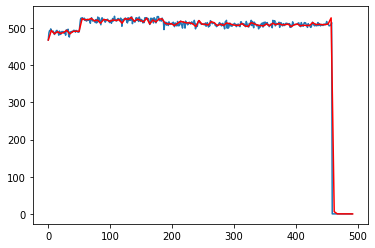

In [ ]:
# фильтрация - пока не нужна!
from scipy.interpolate import Rbf

y = data['data'][1]

rbf = Rbf(range(0,max_len), y, function = 'quintic', smooth = 10)

xnew = np.linspace(0, max_len, num = 100, endpoint = True)
ynew = rbf(xnew)

plt.figure()
plt.plot(y)
plt.plot(xnew, ynew, 'r')
plt.show()

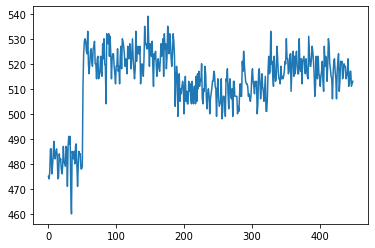

In [ ]:
plt.plot(data['data'][0][0:450])

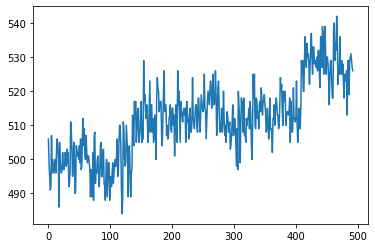

In [ ]:
plt.plot(data['data'][4])

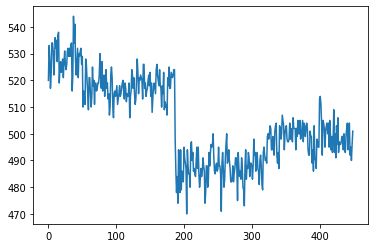

In [ ]:
plt.plot(data['data'][8][0:450])

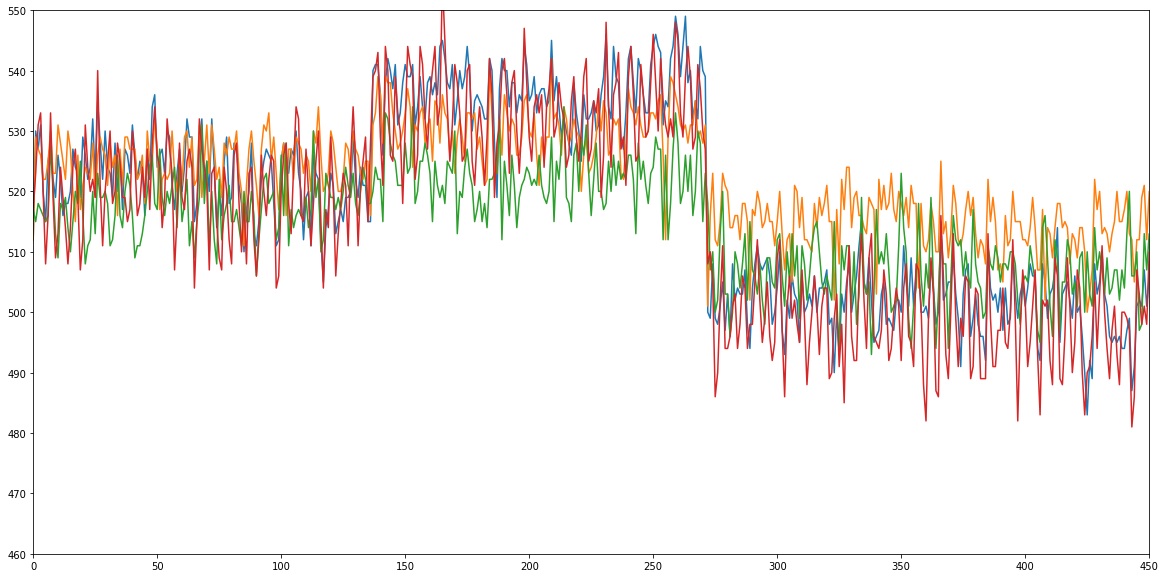

In [ ]:
plt.figure(figsize=(20,10))
for i in data[data['code']==6]['data'][8:12]:

  plt.xlim(0, 450) # cut null
  plt.ylim(460, 550)
  plt.plot(i)

# MNE Lib (https://mne.tools/)

try this example:https://www.kaggle.com/broach/getting-started-with-mne-python-and-subs-1-to-24/data?scriptVersionId=13939515&select=time.csv

doc: https://github.com/mne-tools/mne-python

In [ ]:
!pip install -U mne

In [ ]:
import mne

In [ ]:
import numpy as np
import pandas as pd
from mne import EpochsArray
from mne.channels import make_standard_montage #read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
#from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [ ]:
col_names = pd.read_csv(path_dir_test+'/columnLabels.csv')

In [ ]:
ch_names = list(col_names.columns[4:])
#ch_names = montage.ch_names
# define the channel type, where the first 64 are EEG, next 4 are EOG, then Nose,
#and finally right mastoid (EEG)
ch_type = ['eeg']*64 + ['eog']*4 + ['misc'] + ['eeg']
    
# The sampling rate of the recording
sfreq = 1024  # in Hertz (samples per second)

#print(ch_names)
# read EEG standard montage from mne
montage = make_standard_montage('standard_1005')

# Initialize required fields
info = create_info(ch_names=ch_names, sfreq=20, ch_types=ch_type)
#for debugging:
fname = path_dir_test + '/1.csv'

In [ ]:
#define the function:
def creat_mne_epoch_object(fname, info):
    """Create a mne epoch instance from csv file"""
    # Add some more information
    info['description'] = 'dataset from ' + fname
    
    # Trials were cut from -1.5 to 1.5 seconds
    tmin = -1.5

    # Read EEG file
    data = pd.read_csv(fname, header=None)
    #print(data)
    #and convert it to numpy array:
    npdata = np.array(data)
    
    #the first 4 columns of the data frame are the
    #subject number... subNumber = npdata[:,0]
    #trial number... trialNumber = npdata[:,1]
    #condition number... conditions = npdata[:,2]
    #and sample number (within a trial)... sampleNumber = npdata[:,3]
    
    #sample 1537 is time 0, use that for the event 
    onsets = np.array(np.where(npdata[:,3]==1537))
    conditions = npdata[npdata[:,3]==1537,2]



    #use these to make an events array for mne (middle column are zeros):
    events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape),conditions)))
    #print(events)

    #now we just need EEGdata in a 3D shape (n_epochs, n_channels, n_samples)
    EEGdata = npdata.reshape(len(conditions),3072,74)
    #remove the first 4 columns (non-eeg, described above):
    EEGdata = EEGdata[:,:,4:]
    EEGdata = np.swapaxes(EEGdata,1,2)
    
    #create labels for the conditions, 1, 2, and 3:
    event_id = dict(button_tone=1, playback_tone=2, button_alone=3)
    
    # create raw object 
    custom_epochs = EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)
    return custom_epochs

In [ ]:
custom_epochs = creat_mne_epoch_object(fname, info)

[[1.53600e+03 0.00000e+00 1.00000e+00]
 [4.60800e+03 0.00000e+00 1.00000e+00]
 [7.68000e+03 0.00000e+00 2.00000e+00]
 [1.07520e+04 0.00000e+00 3.00000e+00]
 [1.38240e+04 0.00000e+00 1.00000e+00]
 [1.68960e+04 0.00000e+00 2.00000e+00]
 [1.99680e+04 0.00000e+00 1.00000e+00]
 [2.30400e+04 0.00000e+00 2.00000e+00]
 [2.61120e+04 0.00000e+00 3.00000e+00]
 [2.91840e+04 0.00000e+00 1.00000e+00]
 [3.22560e+04 0.00000e+00 2.00000e+00]
 [3.53280e+04 0.00000e+00 3.00000e+00]
 [3.84000e+04 0.00000e+00 1.00000e+00]
 [4.14720e+04 0.00000e+00 2.00000e+00]
 [4.45440e+04 0.00000e+00 3.00000e+00]
 [4.76160e+04 0.00000e+00 1.00000e+00]
 [5.06880e+04 0.00000e+00 2.00000e+00]
 [5.37600e+04 0.00000e+00 3.00000e+00]
 [5.68320e+04 0.00000e+00 1.00000e+00]
 [5.99040e+04 0.00000e+00 2.00000e+00]
 [6.29760e+04 0.00000e+00 3.00000e+00]
 [6.60480e+04 0.00000e+00 1.00000e+00]
 [6.91200e+04 0.00000e+00 2.00000e+00]
 [7.21920e+04 0.00000e+00 3.00000e+00]
 [7.52640e+04 0.00000e+00 1.00000e+00]
 [7.83360e+04 0.00000e+00

In [ ]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 69])

In [ ]:
picks = pick_types(custom_epochs.info,eeg=True)
    
    #could not filter epochs with mne 0.13, upgraded to 0.15 to get this to work:
    # Filter data for alpha frequency and beta band
    # Note that MNE implements a zero phase (filtfilt) filer
custom_epochs.filter(2,6, picks=picks, method='iir', n_jobs=-1, verbose=False)
    

Number of events,289
Events,button_alone: 95button_tone: 100playback_tone: 94
Time range,-1.500 – 152.050 sec
Baseline,off


In [ ]:
pick_types(custom_epochs.info,eeg=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 69])